In [126]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

## Part 1

In [127]:
df = pd.read_csv("cleveland.csv")

In [128]:
df = df.rename({"num": "disease"}, axis=1)
df["disease"] = df["disease"].apply(lambda x: min(x, 1))
df
df.replace("?", pd.NA, inplace=True)
df = df.dropna()
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


### Standardization

In [129]:
df["thalach"] = (df.thalach - df.thalach.mean()) / df.thalach.std()
df["exang"] = (df.exang - df.exang.mean()) / df.exang.std()
df["oldpeak"] = (df.oldpeak - df.oldpeak.mean()) / df.oldpeak.std()
df["ca"] = df["ca"].astype("float")
df["thal"] = df["thal"].astype("float")
df["ca"] = (df.ca - df.ca.mean()) / df.ca.std()
df["thal"] = (df.thal - df.thal.mean()) / df.thal.std()
X = df[['thalach', 'exang', 'oldpeak', 'ca', 'thal']].values
y = df["disease"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


## k-nearest neighbors function

In [130]:
def knn(n_neighbors, X_train, y_train, X_test, y_test):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean", algorithm="auto")

    fit = nn.fit(X_train)

    distances, indices = fit.kneighbors(X_test)
    y_pred = []

    # print(list(y_test))

    # for i in range(len(X_test)):
    #     zeros = list(y_train.iloc[indices[i]]).count(0)
    #     ones = list(y_train.iloc[indices[i]]).count(1)
    #     if ones > zeros:
    #         y_pred.append(1)
    #     else:
    #         y_pred.append(0)
    for i in range(len(X_test)):
        zeros = list(y_train[indices[i]]).count(0)
        ones = list(y_train[indices[i]]).count(1)
        if ones > zeros:
            y_pred.append(1)
        # In case of equality of numbers we predict zero
        else:
            y_pred.append(0)
    
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[0,1])
    return [p, r, f, s]
    

# Finding the best K

best k -> 31


Text(0, 0.5, 'f-score')

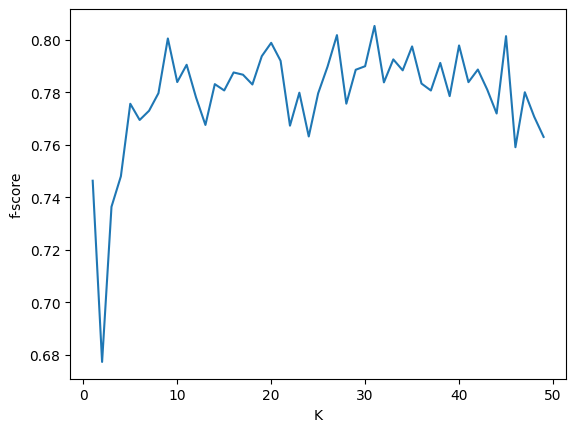

In [131]:
def bestK(n, X, y):
    k_fold = 10

    # Calculate the number of samples per fold
    fold_size = len(X) // k_fold
    
    # Shuffle the dataset
    X = np.array(X)
    y = np.array(y)

    # Shuffle the indices array
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Use the shuffled indices to shuffle both X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    f_score_1 = []
    

    for fold in range(k_fold):
        # Split the dataset into training and testing sets for this fold
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        X_test_fold = X_shuffled[test_start:test_end]
        y_test_fold = y_shuffled[test_start:test_end]


        # Use the remaining data as training set
        X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
        y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
        result = knn(n, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        # print(result)
        f_score_1.append(result[2][1])
    
    return np.mean(f_score_1)

k_range = range(1, 50)
f_scores = [bestK(n, X, y) for n in k_range]
# print(f_scores)
print(f"best k -> {f_scores.index(max(f_scores)) + 1}")
bestK = f_scores.index(max(f_scores)) + 1

plt.plot(k_range, f_scores)
plt.xlabel("K")
plt.ylabel("f-score")




In [132]:
result = knn(bestK, X_train, y_train, X_test, y_test)
print(f'precision={result[0]}, recall={result[1]}, f-score={result[2]}, support={result[3]}') 

precision=[0.72727273 0.88888889], recall=[0.88888889 0.72727273], f-score=[0.8 0.8], support=[27 33]


### Implementation of K-fold cross validation

In [133]:
k_fold = 10

# Calculate the number of samples per fold
fold_size = len(X) // k_fold

# Shuffle the dataset
X = np.array(X)
y = np.array(y)

# Shuffle the indices array
indices = np.arange(len(X))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle both X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f_score_0 = []
f_score_1 = []
support_0 = []
support_1 = []

for fold in range(k_fold):
    # Split the dataset into training and testing sets for this fold
    test_start = fold * fold_size
    test_end = (fold + 1) * fold_size
    X_test_fold = X_shuffled[test_start:test_end]
    y_test_fold = y_shuffled[test_start:test_end]
    
    
    # Use the remaining data as training set
    X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
    y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
    result = knn(bestK, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    # print(result)
    precision_0.append(result[0][0])
    precision_1.append(result[0][1])
    recall_0.append(result[1][0])
    recall_1.append(result[1][1])
    f_score_0.append(result[2][0])
    f_score_1.append(result[2][1])
    support_0.append(result[3][0])
    support_1.append(result[3][1])

print(f"recall_0 -> {(recall_0)}")
print(f"mean recall_0 -> {np.mean(recall_0)}")
print(f"recall_1 -> {(recall_1)}")
print(f"mean recall_1 -> {np.mean(recall_1)}")
print(f"precision_0 -> {(precision_0)}")
print(f"mean precision_0 -> {np.mean(precision_0)}")
print(f"precision_1 -> {(precision_1)}")
print(f"mean precision_1 -> {np.mean(precision_1)}")
print(f"f-score_0 -> {(f_score_0)}")
print(f"mean f-score_0 -> {np.mean(f_score_0)}")
print(f"f-score_1 -> {(f_score_1)}")
print(f"mean f-score_1 -> {np.mean(f_score_1)}")
print(f"support 0 -> {support_0}")
print(f"support 1 -> {support_1}")
    

recall_0 -> [1.0, 0.875, 0.9473684210526315, 0.9333333333333333, 0.8235294117647058, 0.8823529411764706, 0.9333333333333333, 0.8571428571428571, 0.9, 0.8421052631578947]
mean recall_0 -> 0.8994165560961228
recall_1 -> [0.7692307692307693, 0.7692307692307693, 0.7, 0.9285714285714286, 0.75, 0.8333333333333334, 0.42857142857142855, 0.7333333333333333, 0.631578947368421, 0.9]
mean recall_1 -> 0.7443850009639484
precision_0 -> [0.8421052631578947, 0.8235294117647058, 0.8571428571428571, 0.9333333333333333, 0.8235294117647058, 0.8823529411764706, 0.6363636363636364, 0.75, 0.5625, 0.9411764705882353]
mean precision_0 -> 0.8052033325291837
precision_1 -> [1.0, 0.8333333333333334, 0.875, 0.9285714285714286, 0.75, 0.8333333333333334, 0.8571428571428571, 0.8461538461538461, 0.9230769230769231, 0.75]
mean precision_1 -> 0.8596611721611722
f-score_0 -> [0.9142857142857143, 0.8484848484848485, 0.9, 0.9333333333333333, 0.8235294117647058, 0.8823529411764706, 0.7567567567567568, 0.7999999999999999, 0.

## Part 2